<a href="https://colab.research.google.com/github/AloniRegev/Defense-Against-Adversarial-Examples-in-NN/blob/Regev-dev/DL_project_adversary_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUDA available. Training on GPU


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
 trainset: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
           )
Files already downloaded and verified
train set len 40000
validation set len 10000
test set len 10000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 6

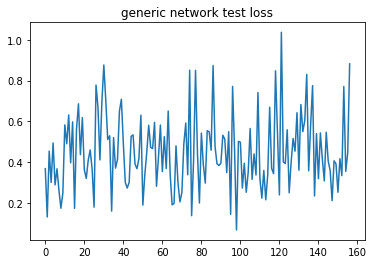

Accuracy: Vanila model on regular test 88.47%


Appling DeepFool attack on Test set
Converting batch no. 0 in 157
Converting batch no. 25 in 157
Converting batch no. 50 in 157
Converting batch no. 75 in 157
Converting batch no. 100 in 157
Converting batch no. 125 in 157
Converting batch no. 150 in 157
ther are 9995 misclassifications in 30000 sempels.
Accuracy: in test of deepfool 0.6668333333333334


DeepFool attack performence:


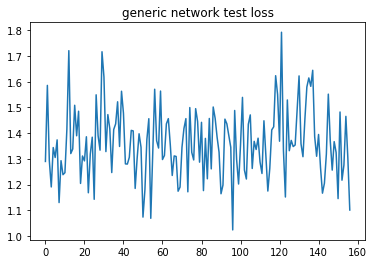

Accuracy: DeepFool attack on regular test 7.45%


Adversarial training on tast loader:


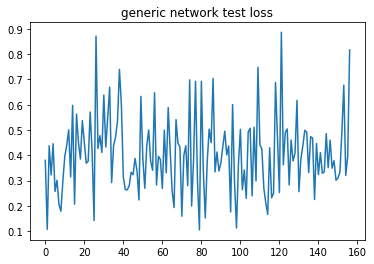

Accuracy: Adversarial Training model on regular test 88.40%


adversarial training on carpeted (deepfool) tast loader:


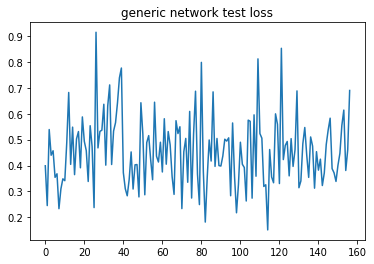

Accuracy: Adversarial Training model on attacked test 85.45%


Starting Feature Squeezing training
Iteration: 0 | Loss: 2.309272527694702 | index 0 
Iteration: 0 | Loss: 1.8092141151428223 | index 100 
Iteration: 0 | Loss: 1.6361061334609985 | index 200 
Iteration: 0 | Loss: 1.8320926427841187 | index 300 
Iteration: 0 | Loss: 1.4956549406051636 | index 400 
Iteration: 0 | Loss: 1.5052788257598877 | index 500 
Iteration: 0 | Loss: 1.2947909832000732 | index 600 
Accuracy: in train 0.38374999165534973


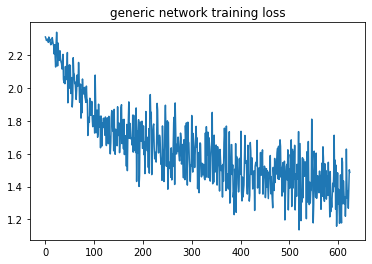

Accuracy: in validation 0.4153999984264374
The Current Loss by validation data: 1.740090415735913
Iteration: 1 | Loss: 1.4944791793823242 | index 0 
Iteration: 1 | Loss: 1.4058806896209717 | index 100 
Iteration: 1 | Loss: 1.6023433208465576 | index 200 
Iteration: 1 | Loss: 1.1784625053405762 | index 300 
Iteration: 1 | Loss: 1.2205469608306885 | index 400 
Iteration: 1 | Loss: 1.256834626197815 | index 500 
Iteration: 1 | Loss: 1.0945948362350464 | index 600 
Accuracy: in train 0.46158748865127563


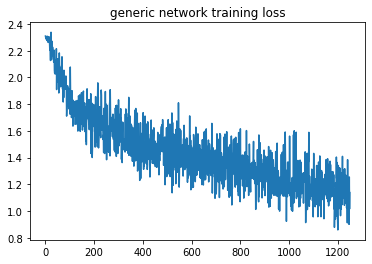

Accuracy: in validation 0.45559999346733093
The Current Loss by validation data: 1.8736313528316035
Iteration: 2 | Loss: 1.3513121604919434 | index 0 
Iteration: 2 | Loss: 1.0865246057510376 | index 100 
Iteration: 2 | Loss: 1.0240401029586792 | index 200 
Iteration: 2 | Loss: 1.0310090780258179 | index 300 
Iteration: 2 | Loss: 0.9339585304260254 | index 400 
Iteration: 2 | Loss: 0.9563934206962585 | index 500 
Iteration: 2 | Loss: 1.003614902496338 | index 600 
Accuracy: in train 0.5113499760627747


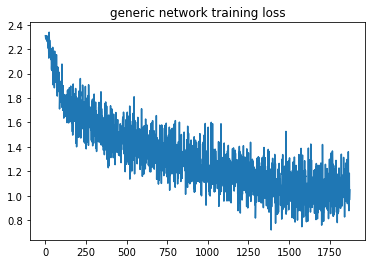

Accuracy: in validation 0.5508999824523926
The Current Loss by validation data: 1.304115708466548
Iteration: 3 | Loss: 1.0733698606491089 | index 0 
Iteration: 3 | Loss: 1.122155785560608 | index 100 
Iteration: 3 | Loss: 0.7597853541374207 | index 200 
Iteration: 3 | Loss: 0.8563409447669983 | index 300 
Iteration: 3 | Loss: 0.7830471992492676 | index 400 
Iteration: 3 | Loss: 0.9523078799247742 | index 500 
Iteration: 3 | Loss: 0.8984044194221497 | index 600 
Accuracy: in train 0.5485812425613403


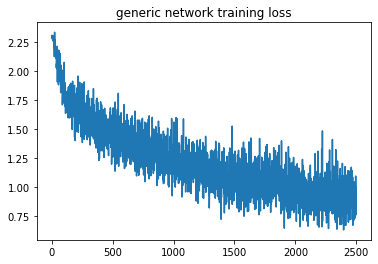

Accuracy: in validation 0.621399998664856
The Current Loss by validation data: 1.1100363431462816
Iteration: 4 | Loss: 1.1078705787658691 | index 0 
Iteration: 4 | Loss: 0.8064448833465576 | index 100 
Iteration: 4 | Loss: 0.7733080387115479 | index 200 
Iteration: 4 | Loss: 0.9436401128768921 | index 300 
Iteration: 4 | Loss: 0.8538908362388611 | index 400 
Iteration: 4 | Loss: 0.7247955203056335 | index 500 
Iteration: 4 | Loss: 0.9494643211364746 | index 600 
Accuracy: in train 0.5771399736404419


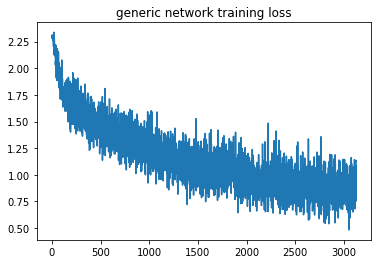

Accuracy: in validation 0.6520999670028687
The Current Loss by validation data: 1.0137625283496394
Iteration: 5 | Loss: 0.9162355661392212 | index 0 
Iteration: 5 | Loss: 0.9550220370292664 | index 100 
Iteration: 5 | Loss: 0.9748635292053223 | index 200 
Iteration: 5 | Loss: 0.9091142416000366 | index 300 
Iteration: 5 | Loss: 0.8618030548095703 | index 400 
Iteration: 5 | Loss: 0.9537383317947388 | index 500 
Iteration: 5 | Loss: 0.8177223205566406 | index 600 
Accuracy: in train 0.5997291803359985


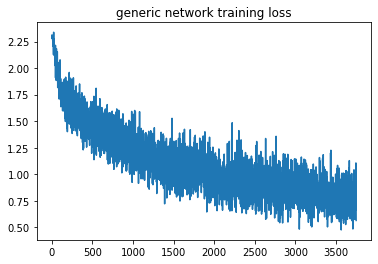

Accuracy: in validation 0.6577000021934509
The Current Loss by validation data: 0.9937254942146836
Iteration: 6 | Loss: 0.7777237892150879 | index 0 
Iteration: 6 | Loss: 0.7168773412704468 | index 100 
Iteration: 6 | Loss: 0.9249132871627808 | index 200 
Iteration: 6 | Loss: 0.594396710395813 | index 300 
Iteration: 6 | Loss: 0.7572596073150635 | index 400 
Iteration: 6 | Loss: 0.9383034110069275 | index 500 
Iteration: 6 | Loss: 0.7254022359848022 | index 600 
Accuracy: in train 0.6192356944084167


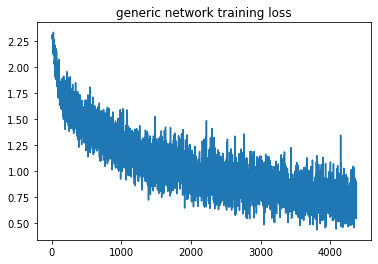

Accuracy: in validation 0.6703999638557434
The Current Loss by validation data: 0.9510690930542672
Iteration: 7 | Loss: 0.6009230613708496 | index 0 
Iteration: 7 | Loss: 0.7405053973197937 | index 100 
Iteration: 7 | Loss: 0.7640112638473511 | index 200 
Iteration: 7 | Loss: 0.76091068983078 | index 300 
Iteration: 7 | Loss: 0.6839841604232788 | index 400 
Iteration: 7 | Loss: 0.5528655052185059 | index 500 
Iteration: 7 | Loss: 0.5980387330055237 | index 600 
Accuracy: in train 0.636256217956543


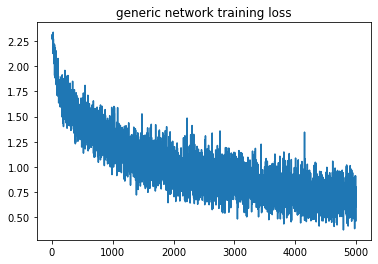

Accuracy: in validation 0.6944999694824219
The Current Loss by validation data: 0.9059921260092668
Iteration: 8 | Loss: 0.6090955138206482 | index 0 
Iteration: 8 | Loss: 0.5392891764640808 | index 100 
Iteration: 8 | Loss: 0.7664473652839661 | index 200 
Iteration: 8 | Loss: 0.7758234143257141 | index 300 
Iteration: 8 | Loss: 0.5230770111083984 | index 400 
Iteration: 8 | Loss: 0.8642423152923584 | index 500 
Iteration: 8 | Loss: 0.7715966701507568 | index 600 
Accuracy: in train 0.6509361267089844


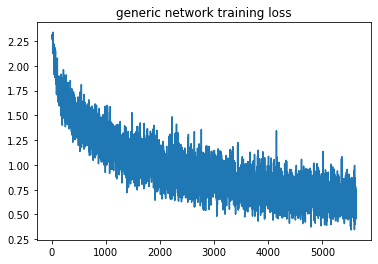

Accuracy: in validation 0.6984999775886536
The Current Loss by validation data: 0.9218426403725982
Iteration: 9 | Loss: 0.5285350680351257 | index 0 
Iteration: 9 | Loss: 0.628219485282898 | index 100 
Iteration: 9 | Loss: 0.5950824022293091 | index 200 
Iteration: 9 | Loss: 0.5035057067871094 | index 300 
Iteration: 9 | Loss: 0.8798422813415527 | index 400 
Iteration: 9 | Loss: 0.7249905467033386 | index 500 
Iteration: 9 | Loss: 0.560653567314148 | index 600 
Accuracy: in train 0.6642299890518188


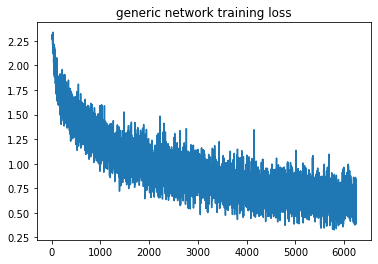

Accuracy: in validation 0.7161999940872192
The Current Loss by validation data: 0.8560875065767082
Iteration: 10 | Loss: 0.6718268394470215 | index 0 
Iteration: 10 | Loss: 0.5538097023963928 | index 100 
Iteration: 10 | Loss: 0.6144010424613953 | index 200 
Iteration: 10 | Loss: 0.5442452430725098 | index 300 
Iteration: 10 | Loss: 0.5255233645439148 | index 400 
Iteration: 10 | Loss: 0.5561880469322205 | index 500 
Iteration: 10 | Loss: 0.6645352840423584 | index 600 
Accuracy: in train 0.6758681535720825


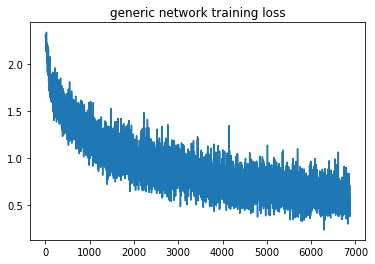

Accuracy: in validation 0.7317999601364136
The Current Loss by validation data: 0.8144551200471866
Iteration: 11 | Loss: 0.49280378222465515 | index 0 
Iteration: 11 | Loss: 0.818016767501831 | index 100 
Iteration: 11 | Loss: 0.48024478554725647 | index 200 
Iteration: 11 | Loss: 0.5020106434822083 | index 300 
Iteration: 11 | Loss: 0.690626323223114 | index 400 
Iteration: 11 | Loss: 0.4721478223800659 | index 500 
Iteration: 11 | Loss: 0.47364696860313416 | index 600 
Accuracy: in train 0.6864458322525024


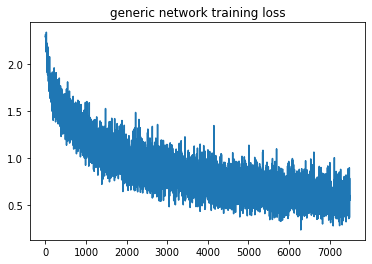

Accuracy: in validation 0.7423999905586243
The Current Loss by validation data: 0.7681042789273961
Iteration: 12 | Loss: 0.6288962364196777 | index 0 
Iteration: 12 | Loss: 0.6783445477485657 | index 100 
Iteration: 12 | Loss: 0.5711413621902466 | index 200 
Iteration: 12 | Loss: 0.33085447549819946 | index 300 
Iteration: 12 | Loss: 0.6273671388626099 | index 400 
Iteration: 12 | Loss: 0.44286641478538513 | index 500 
Iteration: 12 | Loss: 0.22310809791088104 | index 600 
Accuracy: in train 0.6960269212722778


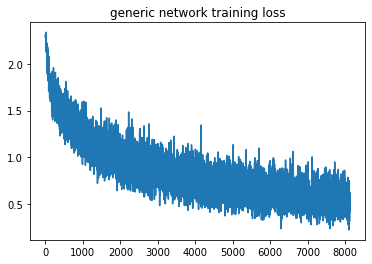

Accuracy: in validation 0.7461000084877014
The Current Loss by validation data: 0.7822748464383896
Iteration: 13 | Loss: 0.31211286783218384 | index 0 
Iteration: 13 | Loss: 0.3633233308792114 | index 100 
Iteration: 13 | Loss: 0.4329541325569153 | index 200 
Iteration: 13 | Loss: 0.6747173070907593 | index 300 
Iteration: 13 | Loss: 0.9207907319068909 | index 400 
Iteration: 13 | Loss: 0.5214748382568359 | index 500 
Iteration: 13 | Loss: 0.5507328510284424 | index 600 
Accuracy: in train 0.7047767639160156


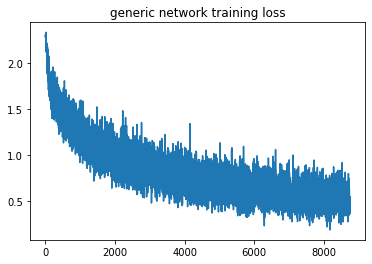

Accuracy: in validation 0.7317000031471252
The Current Loss by validation data: 0.8288755449140148
Iteration: 14 | Loss: 0.5310799479484558 | index 0 
Iteration: 14 | Loss: 0.605265736579895 | index 100 
Iteration: 14 | Loss: 0.4006194770336151 | index 200 
Iteration: 14 | Loss: 0.3568979501724243 | index 300 
Iteration: 14 | Loss: 0.3943568170070648 | index 400 
Iteration: 14 | Loss: 0.5688247084617615 | index 500 
Iteration: 14 | Loss: 0.9258512854576111 | index 600 
Accuracy: in train 0.7128866910934448


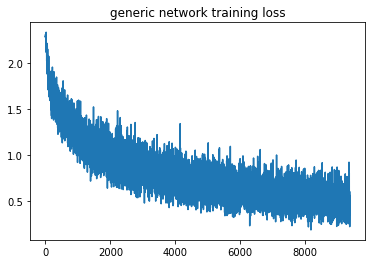

Accuracy: in validation 0.7366999983787537
The Current Loss by validation data: 0.7878947789501992
Iteration: 15 | Loss: 0.36053621768951416 | index 0 
Iteration: 15 | Loss: 0.5715839266777039 | index 100 
Iteration: 15 | Loss: 0.33829259872436523 | index 200 
Iteration: 15 | Loss: 0.4786069095134735 | index 300 
Iteration: 15 | Loss: 0.478059321641922 | index 400 
Iteration: 15 | Loss: 0.6242610812187195 | index 500 
Iteration: 15 | Loss: 0.6430987119674683 | index 600 
Accuracy: in train 0.7202640175819397


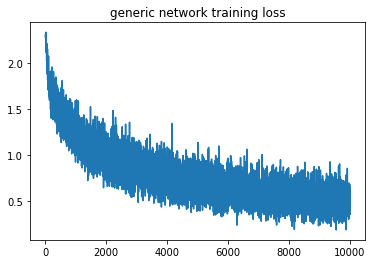

Accuracy: in validation 0.7443000078201294
The Current Loss by validation data: 0.8095656128446008
Iteration: 16 | Loss: 0.4428456425666809 | index 0 
Iteration: 16 | Loss: 0.35853418707847595 | index 100 
Iteration: 16 | Loss: 0.3161698877811432 | index 200 
Iteration: 16 | Loss: 0.4931076467037201 | index 300 
Iteration: 16 | Loss: 0.42075833678245544 | index 400 
Iteration: 16 | Loss: 0.6396867632865906 | index 500 
Iteration: 16 | Loss: 0.2778934836387634 | index 600 
Accuracy: in train 0.727239727973938


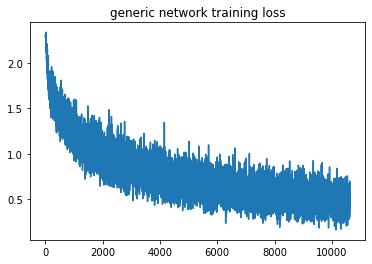

Accuracy: in validation 0.7631999850273132
The Current Loss by validation data: 0.7469792910821879
Iteration: 17 | Loss: 0.3299199342727661 | index 0 
Iteration: 17 | Loss: 0.6256709694862366 | index 100 
Iteration: 17 | Loss: 0.5222386717796326 | index 200 
Iteration: 17 | Loss: 0.43523386120796204 | index 300 
Iteration: 17 | Loss: 0.45130449533462524 | index 400 
Iteration: 17 | Loss: 0.509880006313324 | index 500 
Iteration: 17 | Loss: 0.3323954641819 | index 600 
Accuracy: in train 0.7337833642959595


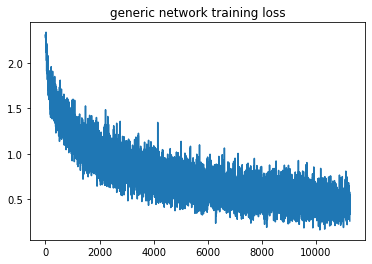

Accuracy: in validation 0.7648999691009521
The Current Loss by validation data: 0.7230396128384171
Iteration: 18 | Loss: 0.37541598081588745 | index 0 
Iteration: 18 | Loss: 0.6795162558555603 | index 100 
Iteration: 18 | Loss: 0.3650188148021698 | index 200 
Iteration: 18 | Loss: 0.58833247423172 | index 300 
Iteration: 18 | Loss: 0.35927948355674744 | index 400 
Iteration: 18 | Loss: 0.4812357723712921 | index 500 
Iteration: 18 | Loss: 0.42663466930389404 | index 600 
Accuracy: in train 0.7399395108222961


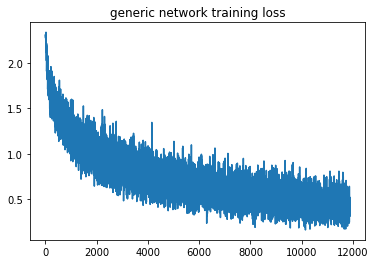

Accuracy: in validation 0.7888000011444092
The Current Loss by validation data: 0.6610045133122973
Iteration: 19 | Loss: 0.39365285634994507 | index 0 
Iteration: 19 | Loss: 0.4059787690639496 | index 100 
Iteration: 19 | Loss: 0.5081205368041992 | index 200 
Iteration: 19 | Loss: 0.3341195285320282 | index 300 
Iteration: 19 | Loss: 0.3266182243824005 | index 400 
Iteration: 19 | Loss: 0.4583466053009033 | index 500 
Iteration: 19 | Loss: 0.29422885179519653 | index 600 
Accuracy: in train 0.7457987070083618


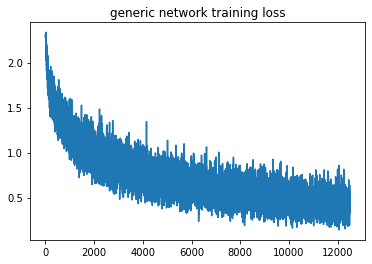

Accuracy: in validation 0.7820000052452087
The Current Loss by validation data: 0.6747263172629533
Iteration: 20 | Loss: 0.26995864510536194 | index 0 
Iteration: 20 | Loss: 0.31220680475234985 | index 100 
Iteration: 20 | Loss: 0.2750350832939148 | index 200 
Iteration: 20 | Loss: 0.3772892951965332 | index 300 
Iteration: 20 | Loss: 0.387896865606308 | index 400 
Iteration: 20 | Loss: 0.36815500259399414 | index 500 
Iteration: 20 | Loss: 0.3917312026023865 | index 600 
Accuracy: in train 0.7512249946594238


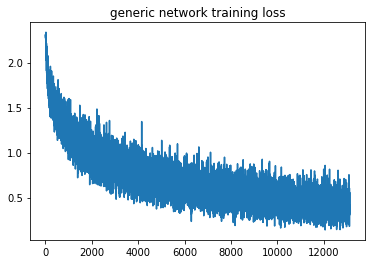

Accuracy: in validation 0.7797999978065491
The Current Loss by validation data: 0.6994522257595305
Iteration: 21 | Loss: 0.37971416115760803 | index 0 
Iteration: 21 | Loss: 0.2608170509338379 | index 100 
Iteration: 21 | Loss: 0.40382057428359985 | index 200 
Iteration: 21 | Loss: 0.4698706269264221 | index 300 
Iteration: 21 | Loss: 0.42546510696411133 | index 400 
Iteration: 21 | Loss: 0.46308839321136475 | index 500 
Iteration: 21 | Loss: 0.33069002628326416 | index 600 
Accuracy: in train 0.7563738226890564


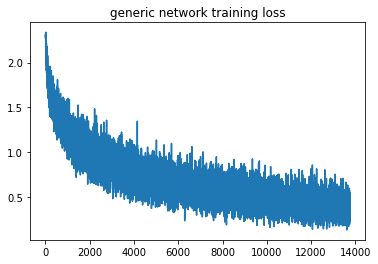

Accuracy: in validation 0.7960999608039856
The Current Loss by validation data: 0.6621931316746268
Iteration: 22 | Loss: 0.36790236830711365 | index 0 
Iteration: 22 | Loss: 0.4029463529586792 | index 100 
Iteration: 22 | Loss: 0.47070860862731934 | index 200 
Iteration: 22 | Loss: 0.23921218514442444 | index 300 
Iteration: 22 | Loss: 0.3768714368343353 | index 400 
Iteration: 22 | Loss: 0.38561078906059265 | index 500 
Iteration: 22 | Loss: 0.2763228416442871 | index 600 
Accuracy: in train 0.761229395866394


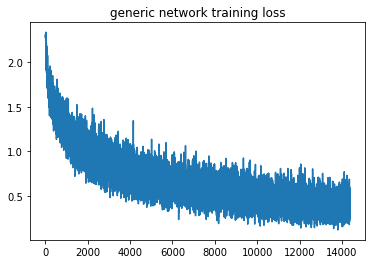

Accuracy: in validation 0.774399995803833
The Current Loss by validation data: 0.7214098542359224
Iteration: 23 | Loss: 0.310468465089798 | index 0 
Iteration: 23 | Loss: 0.3600514531135559 | index 100 
Iteration: 23 | Loss: 0.4860580265522003 | index 200 
Iteration: 23 | Loss: 0.3825329542160034 | index 300 
Iteration: 23 | Loss: 0.33297696709632874 | index 400 
Iteration: 23 | Loss: 0.3530709147453308 | index 500 
Iteration: 23 | Loss: 0.3580916225910187 | index 600 
Accuracy: in train 0.766014575958252


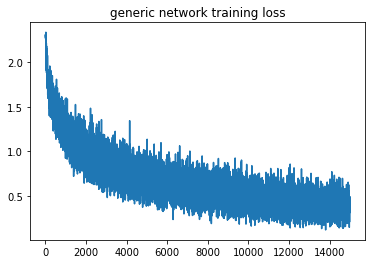

Accuracy: in validation 0.786899983882904
The Current Loss by validation data: 0.6807148688158412
Iteration: 24 | Loss: 0.21442261338233948 | index 0 
Iteration: 24 | Loss: 0.31176069378852844 | index 100 
Iteration: 24 | Loss: 0.21625137329101562 | index 200 
Iteration: 24 | Loss: 0.3837791085243225 | index 300 
Iteration: 24 | Loss: 0.22921770811080933 | index 400 
Iteration: 24 | Loss: 0.32390889525413513 | index 500 
Iteration: 24 | Loss: 0.3309174180030823 | index 600 
Accuracy: in train 0.7704299688339233


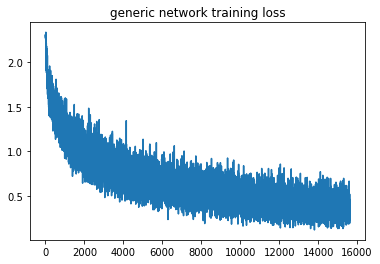

Accuracy: in validation 0.7854999899864197
The Current Loss by validation data: 0.6769205384953006
Iteration: 25 | Loss: 0.48835310339927673 | index 0 
Iteration: 25 | Loss: 0.15188126266002655 | index 100 
Iteration: 25 | Loss: 0.2679677903652191 | index 200 
Iteration: 25 | Loss: 0.31703078746795654 | index 300 
Iteration: 25 | Loss: 0.3718082308769226 | index 400 
Iteration: 25 | Loss: 0.4305698275566101 | index 500 
Iteration: 25 | Loss: 0.28922271728515625 | index 600 
Accuracy: in train 0.7747615575790405


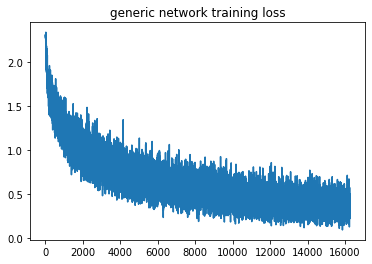

Accuracy: in validation 0.7871999740600586
The Current Loss by validation data: 0.6819924334431909
Iteration: 26 | Loss: 0.38484176993370056 | index 0 
Iteration: 26 | Loss: 0.2074611485004425 | index 100 
Iteration: 26 | Loss: 0.45433664321899414 | index 200 
Iteration: 26 | Loss: 0.3747381269931793 | index 300 
Iteration: 26 | Loss: 0.33613866567611694 | index 400 
Iteration: 26 | Loss: 0.37130799889564514 | index 500 
Iteration: 26 | Loss: 0.5269260406494141 | index 600 
Accuracy: in train 0.7787990570068359


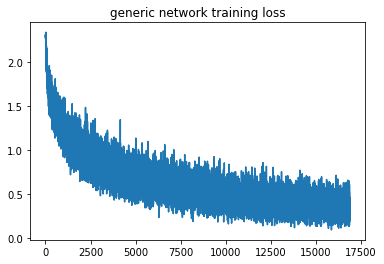

Accuracy: in validation 0.7800999879837036
The Current Loss by validation data: 0.6999337025888407
Iteration: 27 | Loss: 0.30596399307250977 | index 0 
Iteration: 27 | Loss: 0.3057994544506073 | index 100 
Iteration: 27 | Loss: 0.3260631859302521 | index 200 
Iteration: 27 | Loss: 0.44709914922714233 | index 300 
Iteration: 27 | Loss: 0.5283336043357849 | index 400 
Iteration: 27 | Loss: 0.2856050729751587 | index 500 
Iteration: 27 | Loss: 0.452754944562912 | index 600 
Accuracy: in train 0.7826464176177979


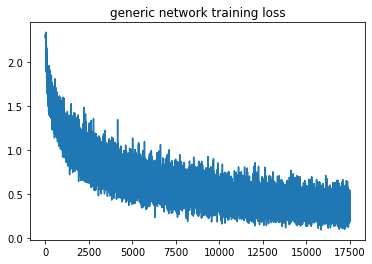

Accuracy: in validation 0.7708999514579773
The Current Loss by validation data: 0.7531889510002865
Iteration: 28 | Loss: 0.46793094277381897 | index 0 
Iteration: 28 | Loss: 0.4351412355899811 | index 100 
Iteration: 28 | Loss: 0.2936474084854126 | index 200 
Iteration: 28 | Loss: 0.3226410150527954 | index 300 
Iteration: 28 | Loss: 0.20216034352779388 | index 400 
Iteration: 28 | Loss: 0.40518152713775635 | index 500 
Iteration: 28 | Loss: 0.1527807116508484 | index 600 
Accuracy: in train 0.786386251449585


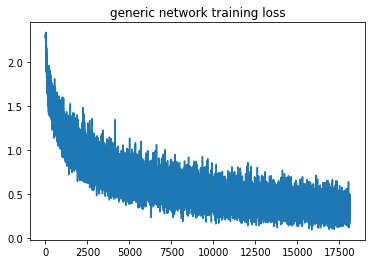

Accuracy: in validation 0.7799999713897705
The Current Loss by validation data: 0.7027889264237349
Iteration: 29 | Loss: 0.23865289986133575 | index 0 
Iteration: 29 | Loss: 0.37492644786834717 | index 100 
Iteration: 29 | Loss: 0.3567671477794647 | index 200 
Iteration: 29 | Loss: 0.2795756161212921 | index 300 
Iteration: 29 | Loss: 0.28180545568466187 | index 400 
Iteration: 29 | Loss: 0.3111056685447693 | index 500 
Iteration: 29 | Loss: 0.2770293951034546 | index 600 
Accuracy: in train 0.7898708581924438


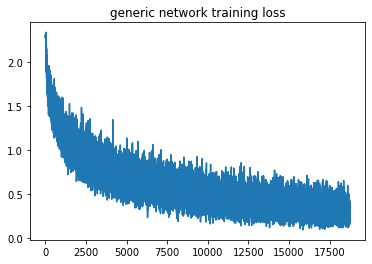

Accuracy: in validation 0.786300003528595
The Current Loss by validation data: 0.698189902457462
Iteration: 30 | Loss: 0.191872239112854 | index 0 
Iteration: 30 | Loss: 0.19308072328567505 | index 100 
Iteration: 30 | Loss: 0.3172091841697693 | index 200 
Iteration: 30 | Loss: 0.19508203864097595 | index 300 
Iteration: 30 | Loss: 0.26319119334220886 | index 400 
Iteration: 30 | Loss: 0.38022446632385254 | index 500 
Iteration: 30 | Loss: 0.42210471630096436 | index 600 
Accuracy: in train 0.7933201789855957


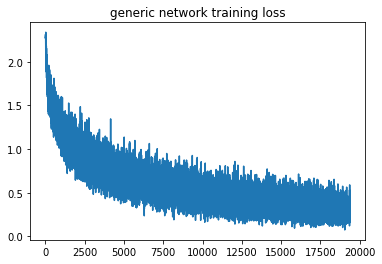

Accuracy: in validation 0.7950999736785889
The Current Loss by validation data: 0.6687638073400327
Iteration: 31 | Loss: 0.2750323414802551 | index 0 
Iteration: 31 | Loss: 0.19059553742408752 | index 100 
Iteration: 31 | Loss: 0.4348737895488739 | index 200 
Iteration: 31 | Loss: 0.2913743853569031 | index 300 
Iteration: 31 | Loss: 0.3396998643875122 | index 400 
Iteration: 31 | Loss: 0.35886502265930176 | index 500 
Iteration: 31 | Loss: 0.3222023844718933 | index 600 
Accuracy: in train 0.7966398000717163


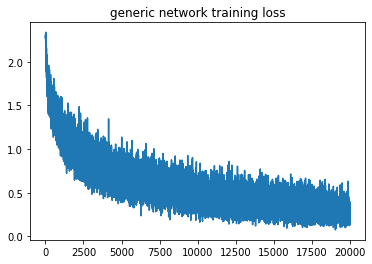

Accuracy: in validation 0.8034999966621399
The Current Loss by validation data: 0.6621679843990667
Iteration: 32 | Loss: 0.15867622196674347 | index 0 
Iteration: 32 | Loss: 0.35286545753479004 | index 100 
Iteration: 32 | Loss: 0.3879007399082184 | index 200 
Iteration: 32 | Loss: 0.2273171991109848 | index 300 
Iteration: 32 | Loss: 0.2742365300655365 | index 400 
Iteration: 32 | Loss: 0.29524171352386475 | index 500 
Iteration: 32 | Loss: 0.25605377554893494 | index 600 
Accuracy: in train 0.7998772859573364


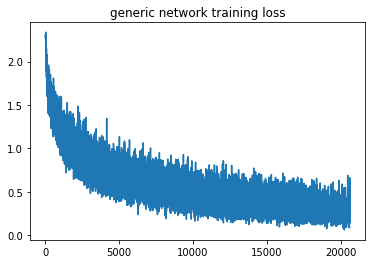

Accuracy: in validation 0.7943999767303467
The Current Loss by validation data: 0.7041719079397286
Iteration: 33 | Loss: 0.24503223598003387 | index 0 
Iteration: 33 | Loss: 0.22090235352516174 | index 100 
Iteration: 33 | Loss: 0.45664310455322266 | index 200 
Iteration: 33 | Loss: 0.16130124032497406 | index 300 
Iteration: 33 | Loss: 0.21134406328201294 | index 400 
Iteration: 33 | Loss: 0.21223121881484985 | index 500 
Iteration: 33 | Loss: 0.19876939058303833 | index 600 
Accuracy: in train 0.8029426336288452


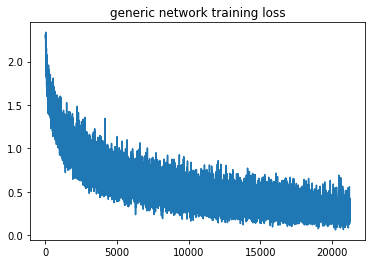

Accuracy: in validation 0.7996000051498413
The Current Loss by validation data: 0.6532435677233775
Iteration: 34 | Loss: 0.12033639848232269 | index 0 
Iteration: 34 | Loss: 0.16511589288711548 | index 100 
Iteration: 34 | Loss: 0.1852160543203354 | index 200 
Iteration: 34 | Loss: 0.32550185918807983 | index 300 
Iteration: 34 | Loss: 0.2540423274040222 | index 400 
Iteration: 34 | Loss: 0.2946781516075134 | index 500 
Iteration: 34 | Loss: 0.3398551940917969 | index 600 
Accuracy: in train 0.8059671521186829


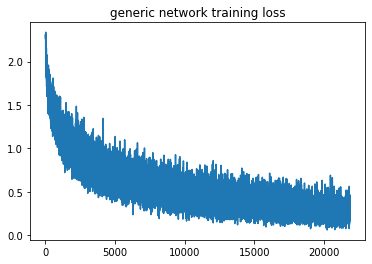

Accuracy: in validation 0.8057999610900879
The Current Loss by validation data: 0.6541578029371371
Iteration: 35 | Loss: 0.1947561353445053 | index 0 
Iteration: 35 | Loss: 0.42934897541999817 | index 100 
Iteration: 35 | Loss: 0.11693882942199707 | index 200 
Iteration: 35 | Loss: 0.25376278162002563 | index 300 
Iteration: 35 | Loss: 0.17177408933639526 | index 400 
Iteration: 35 | Loss: 0.16961264610290527 | index 500 
Iteration: 35 | Loss: 0.1922328919172287 | index 600 
Accuracy: in train 0.8088972568511963


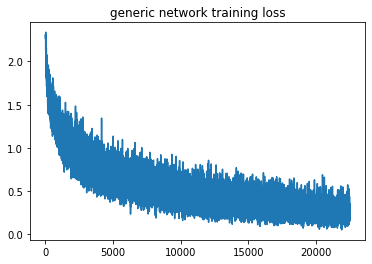

Accuracy: in validation 0.7965999841690063
The Current Loss by validation data: 0.6877627040550207
Iteration: 36 | Loss: 0.2617446184158325 | index 0 
Iteration: 36 | Loss: 0.16306178271770477 | index 100 
Iteration: 36 | Loss: 0.17201858758926392 | index 200 
Iteration: 36 | Loss: 0.27720996737480164 | index 300 
Iteration: 36 | Loss: 0.19149650633335114 | index 400 
Iteration: 36 | Loss: 0.23433463275432587 | index 500 
Iteration: 36 | Loss: 0.16352073848247528 | index 600 
Accuracy: in train 0.8117513656616211


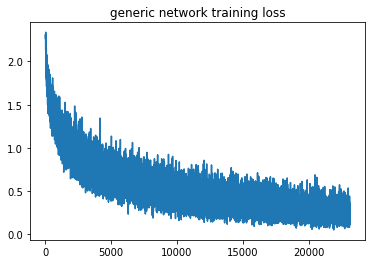

Accuracy: in validation 0.7949999570846558
The Current Loss by validation data: 0.6844174332299809
Iteration: 37 | Loss: 0.23385706543922424 | index 0 
Iteration: 37 | Loss: 0.19757772982120514 | index 100 
Iteration: 37 | Loss: 0.19601969420909882 | index 200 
Iteration: 37 | Loss: 0.5310490727424622 | index 300 
Iteration: 37 | Loss: 0.20033623278141022 | index 400 
Iteration: 37 | Loss: 0.16590626537799835 | index 500 
Iteration: 37 | Loss: 0.19487789273262024 | index 600 
Accuracy: in train 0.8144855499267578


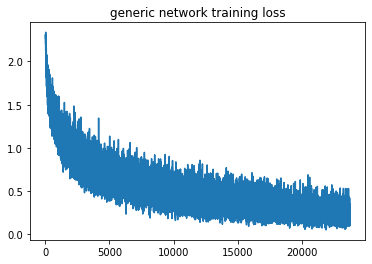

Accuracy: in validation 0.7996000051498413
The Current Loss by validation data: 0.7118643832624338
Iteration: 38 | Loss: 0.18716688454151154 | index 0 
Iteration: 38 | Loss: 0.15266568958759308 | index 100 
Iteration: 38 | Loss: 0.32471397519111633 | index 200 
Iteration: 38 | Loss: 0.2066403031349182 | index 300 
Iteration: 38 | Loss: 0.11457524448633194 | index 400 
Iteration: 38 | Loss: 0.15432171523571014 | index 500 
Iteration: 38 | Loss: 0.2684575617313385 | index 600 
Accuracy: in train 0.8171711564064026


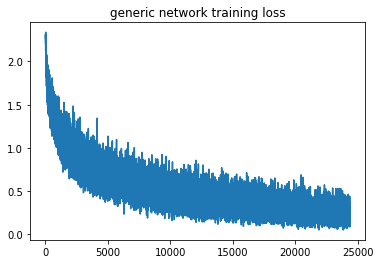

Accuracy: in validation 0.8091999888420105
The Current Loss by validation data: 0.6554201968536255
Iteration: 39 | Loss: 0.27811339497566223 | index 0 
Iteration: 39 | Loss: 0.15102696418762207 | index 100 
Iteration: 39 | Loss: 0.13276372849941254 | index 200 
Iteration: 39 | Loss: 0.20841825008392334 | index 300 
Iteration: 39 | Loss: 0.1620677262544632 | index 400 
Iteration: 39 | Loss: 0.293960303068161 | index 500 
Iteration: 39 | Loss: 0.2990603744983673 | index 600 
Accuracy: in train 0.819724977016449


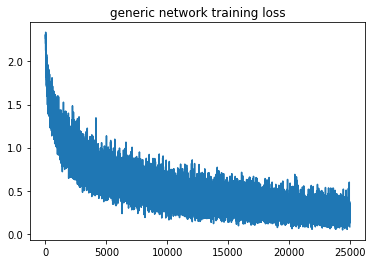

Accuracy: in validation 0.7954999804496765
The Current Loss by validation data: 0.6940499815591581
Iteration: 40 | Loss: 0.42102786898612976 | index 0 
Iteration: 40 | Loss: 0.3062451183795929 | index 100 
Iteration: 40 | Loss: 0.29164159297943115 | index 200 
Iteration: 40 | Loss: 0.16142025589942932 | index 300 
Iteration: 40 | Loss: 0.25666454434394836 | index 400 
Iteration: 40 | Loss: 0.30031105875968933 | index 500 
Iteration: 40 | Loss: 0.42647355794906616 | index 600 
Accuracy: in train 0.8222134113311768


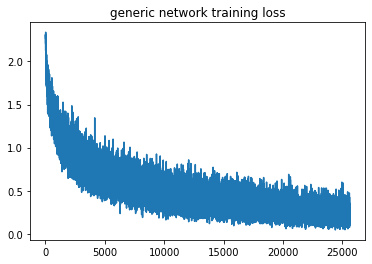

Accuracy: in validation 0.7902999520301819
The Current Loss by validation data: 0.7692140236402013
Iteration: 41 | Loss: 0.2673960328102112 | index 0 
Iteration: 41 | Loss: 0.28083619475364685 | index 100 
Iteration: 41 | Loss: 0.3451375961303711 | index 200 
Iteration: 41 | Loss: 0.2553160488605499 | index 300 
Iteration: 41 | Loss: 0.2528490424156189 | index 400 
Iteration: 41 | Loss: 0.17785069346427917 | index 500 
Iteration: 41 | Loss: 0.17849360406398773 | index 600 
Accuracy: in train 0.8246338963508606


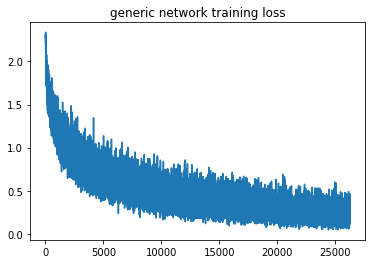

Accuracy: in validation 0.812999963760376
The Current Loss by validation data: 0.6436889646159616
Iteration: 42 | Loss: 0.27217480540275574 | index 0 
Iteration: 42 | Loss: 0.10512666404247284 | index 100 
Iteration: 42 | Loss: 0.2041720151901245 | index 200 
Iteration: 42 | Loss: 0.09757370501756668 | index 300 
Iteration: 42 | Loss: 0.26963621377944946 | index 400 
Iteration: 42 | Loss: 0.20894335210323334 | index 500 
Iteration: 42 | Loss: 0.22600135207176208 | index 600 
Accuracy: in train 0.8269761800765991


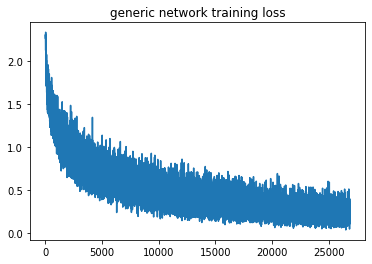

Accuracy: in validation 0.7967999577522278
The Current Loss by validation data: 0.7326873595927171
Iteration: 43 | Loss: 0.13503466546535492 | index 0 
Iteration: 43 | Loss: 0.26075127720832825 | index 100 
Iteration: 43 | Loss: 0.14824621379375458 | index 200 
Iteration: 43 | Loss: 0.0886719673871994 | index 300 
Iteration: 43 | Loss: 0.22780369222164154 | index 400 
Iteration: 43 | Loss: 0.1449919492006302 | index 500 
Iteration: 43 | Loss: 0.3291109502315521 | index 600 
Accuracy: in train 0.8292858004570007


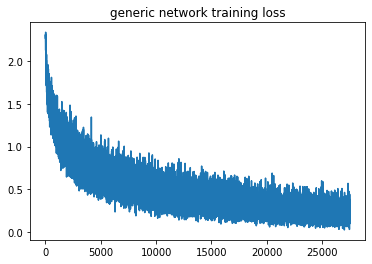

Accuracy: in validation 0.789900004863739
The Current Loss by validation data: 0.7551044115594997
Iteration: 44 | Loss: 0.11218832433223724 | index 0 
Iteration: 44 | Loss: 0.21261772513389587 | index 100 
Iteration: 44 | Loss: 0.1292043775320053 | index 200 
Iteration: 44 | Loss: 0.26994097232818604 | index 300 
Iteration: 44 | Loss: 0.10079976171255112 | index 400 
Iteration: 44 | Loss: 0.06293576955795288 | index 500 
Iteration: 44 | Loss: 0.18699270486831665 | index 600 
Accuracy: in train 0.8314833641052246


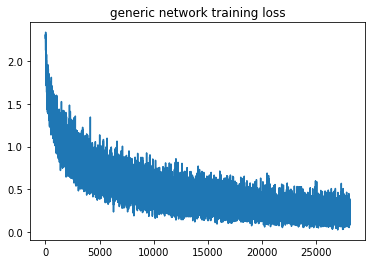

Accuracy: in validation 0.7964999675750732
The Current Loss by validation data: 0.7262995625567285
Iteration: 45 | Loss: 0.2297322005033493 | index 0 
Iteration: 45 | Loss: 0.13456788659095764 | index 100 
Iteration: 45 | Loss: 0.29536953568458557 | index 200 
Iteration: 45 | Loss: 0.14020517468452454 | index 300 
Iteration: 45 | Loss: 0.2040337473154068 | index 400 
Iteration: 45 | Loss: 0.09950527548789978 | index 500 
Iteration: 45 | Loss: 0.12015954405069351 | index 600 
Accuracy: in train 0.8336750268936157


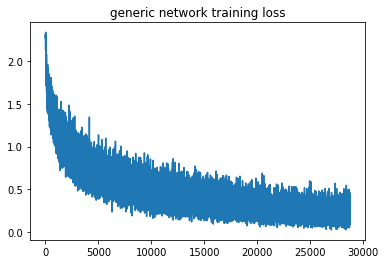

Accuracy: in validation 0.7975999712944031
The Current Loss by validation data: 0.702155786145265
Iteration: 46 | Loss: 0.14675739407539368 | index 0 
Iteration: 46 | Loss: 0.2650506794452667 | index 100 
Iteration: 46 | Loss: 0.2750013768672943 | index 200 
Iteration: 46 | Loss: 0.09327965974807739 | index 300 
Iteration: 46 | Loss: 0.11268426477909088 | index 400 
Iteration: 46 | Loss: 0.13218949735164642 | index 500 
Iteration: 46 | Loss: 0.11390537768602371 | index 600 
Accuracy: in train 0.8358260989189148


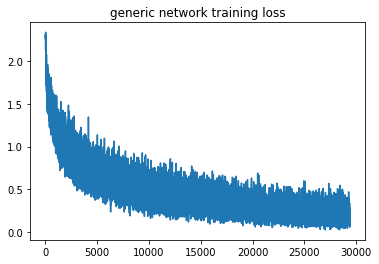

Accuracy: in validation 0.8079999685287476
The Current Loss by validation data: 0.6688894529821007
Iteration: 47 | Loss: 0.07748763263225555 | index 0 
Iteration: 47 | Loss: 0.20684397220611572 | index 100 
Iteration: 47 | Loss: 0.19345302879810333 | index 200 
Iteration: 47 | Loss: 0.18222805857658386 | index 300 
Iteration: 47 | Loss: 0.20020104944705963 | index 400 
Iteration: 47 | Loss: 0.06328894197940826 | index 500 
Iteration: 47 | Loss: 0.17730677127838135 | index 600 
Accuracy: in train 0.8378562331199646


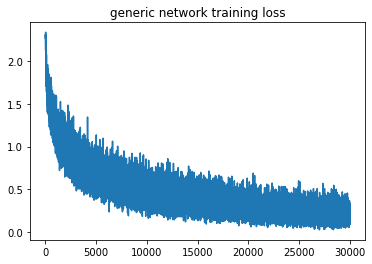

Accuracy: in validation 0.7998999953269958
The Current Loss by validation data: 0.7538026153661643
Iteration: 48 | Loss: 0.2373967319726944 | index 0 
Iteration: 48 | Loss: 0.1931353360414505 | index 100 
Iteration: 48 | Loss: 0.14352303743362427 | index 200 
Iteration: 48 | Loss: 0.25267037749290466 | index 300 
Iteration: 48 | Loss: 0.06386955082416534 | index 400 
Iteration: 48 | Loss: 0.22275567054748535 | index 500 
Iteration: 48 | Loss: 0.12298661470413208 | index 600 
Accuracy: in train 0.8398867249488831


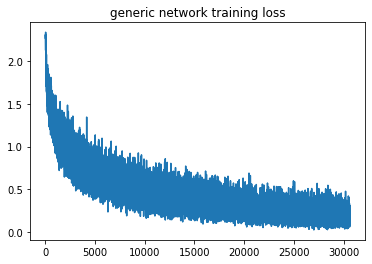

Accuracy: in validation 0.78329998254776
The Current Loss by validation data: 0.8905686324189424
Iteration: 49 | Loss: 0.1753961443901062 | index 0 
Iteration: 49 | Loss: 0.2923291027545929 | index 100 
Iteration: 49 | Loss: 0.34952256083488464 | index 200 
Iteration: 49 | Loss: 0.23123596608638763 | index 300 
Iteration: 49 | Loss: 0.17694756388664246 | index 400 
Iteration: 49 | Loss: 0.11755707114934921 | index 500 
Iteration: 49 | Loss: 0.11119271069765091 | index 600 
Accuracy: in train 0.8418315052986145


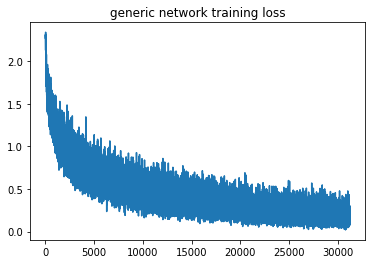

Accuracy: in validation 0.8190000057220459
The Current Loss by validation data: 0.6702688569855538
Iteration: 50 | Loss: 0.07888709008693695 | index 0 
Iteration: 50 | Loss: 0.20262841880321503 | index 100 
Iteration: 50 | Loss: 0.0929928794503212 | index 200 
Iteration: 50 | Loss: 0.14721770584583282 | index 300 
Iteration: 50 | Loss: 0.12485839426517487 | index 400 
Iteration: 50 | Loss: 0.16206569969654083 | index 500 
Iteration: 50 | Loss: 0.19350148737430573 | index 600 
Accuracy: in train 0.8437671661376953


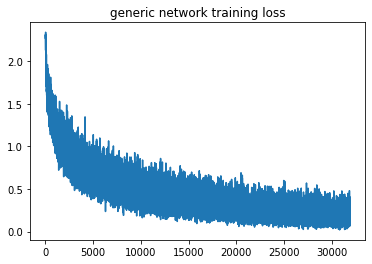

Accuracy: in validation 0.8016999959945679
The Current Loss by validation data: 0.7428653549616504
Iteration: 51 | Loss: 0.2255288064479828 | index 0 
Iteration: 51 | Loss: 0.08820134401321411 | index 100 
Iteration: 51 | Loss: 0.25842171907424927 | index 200 
Iteration: 51 | Loss: 0.1244053989648819 | index 300 
Iteration: 51 | Loss: 0.15070222318172455 | index 400 
Iteration: 51 | Loss: 0.130479633808136 | index 500 
Iteration: 51 | Loss: 0.09053540974855423 | index 600 
Accuracy: in train 0.8456235527992249


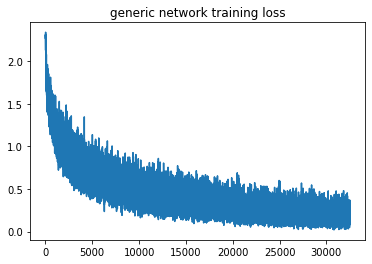

Accuracy: in validation 0.7936999797821045
The Current Loss by validation data: 0.762831952541497
Iteration: 52 | Loss: 0.17437881231307983 | index 0 
Iteration: 52 | Loss: 0.19277580082416534 | index 100 
Iteration: 52 | Loss: 0.14315520226955414 | index 200 
Iteration: 52 | Loss: 0.2743144929409027 | index 300 
Iteration: 52 | Loss: 0.08413472026586533 | index 400 
Iteration: 52 | Loss: 0.12614911794662476 | index 500 
Iteration: 52 | Loss: 0.23535223305225372 | index 600 
Accuracy: in train 0.8474306464195251


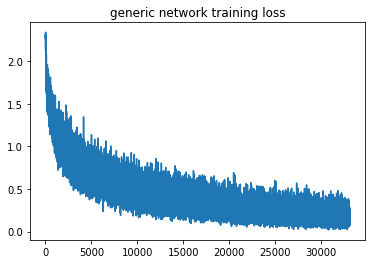

Accuracy: in validation 0.8008999824523926
The Current Loss by validation data: 0.7347487949641647
Iteration: 53 | Loss: 0.13626731932163239 | index 0 
Iteration: 53 | Loss: 0.199609637260437 | index 100 
Iteration: 53 | Loss: 0.2317415326833725 | index 200 
Iteration: 53 | Loss: 0.22102360427379608 | index 300 
Iteration: 53 | Loss: 0.12219082564115524 | index 400 
Iteration: 53 | Loss: 0.11747929453849792 | index 500 
Iteration: 53 | Loss: 0.1290309578180313 | index 600 
Accuracy: in train 0.849218487739563


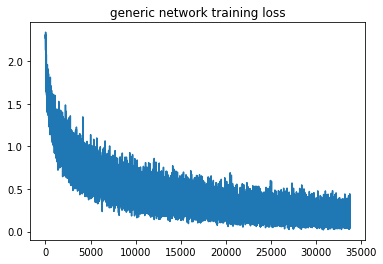

Accuracy: in validation 0.7963999509811401
The Current Loss by validation data: 0.7878458050026256
Iteration: 54 | Loss: 0.0717812180519104 | index 0 
Iteration: 54 | Loss: 0.12027142941951752 | index 100 
Iteration: 54 | Loss: 0.1894230991601944 | index 200 
Iteration: 54 | Loss: 0.09514077752828598 | index 300 
Iteration: 54 | Loss: 0.2754504084587097 | index 400 


KeyboardInterrupt: ignored

In [1]:
from torch._C import NoneType
import torch
import torchvision
import torchvision.datasets as datasets
from torch import optim
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data
from torchsummary import summary

import copy
from PIL import Image
from scipy import ndimage
from tabulate import tabulate


def load_dataset():
    transform_train = transforms.Compose([
        # agmentation below
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        # regular normalization
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    # Normalize the test set same as training set without augmentation
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    print(f' trainset: {trainset}')
    # print(f' trainset shape: {trainset.size()}')

    ## script to find mean
    # data = trainset.data / 255  # data is numpy array
    #
    # mean = data.mean(axis=(0, 1, 2))
    # std = data.std(axis=(0, 1, 2))
    # print(f"Mean : {mean}   STD: {std}")  # Mean : [0.491 0.482 0.446]   STD: [0.247 0.243 0.261]

    cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True,
                                     transform=transform_test)  # transform_test
    cifar_trainset, cifar_valset = data.random_split(trainset, [int(len(trainset) * 0.8), int(len(
        trainset) * 0.2)])  # split the trainset to trainset and validation set in 80%-20% retio

    print('train set len', len(cifar_trainset))
    print('validation set len', len(cifar_valset))
    print('test set len', len(cifar_testset))

    number_workers = 0
    if device == torch.device('cuda'):
        number_workers = 2
    train_loader = data.DataLoader(cifar_trainset, shuffle=True, batch_size=64, num_workers=number_workers)
    val_loader = data.DataLoader(cifar_valset, shuffle=False, batch_size=64, num_workers=number_workers)
    test_loader = data.DataLoader(cifar_testset, shuffle=False, batch_size=64, num_workers=number_workers)

    test_for_adv = data.DataLoader(cifar_testset, shuffle=False, batch_size=1)
    train_for_adv = data.DataLoader(cifar_trainset, shuffle=True, batch_size=1)
    return train_loader, val_loader, test_loader, test_for_adv, train_for_adv


# model3:  with dropout, with batch, without fc layers


class CNN_model(nn.Module):  # TODO: fix so I get correct dimensions of output
    def __init__(self):
        super(CNN_model, self).__init__()
        self.feature_extractor = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=1),

        )

    def forward(self, x):
        # conv layers
        features = self.feature_extractor(x)
        # print("features shape:", features.shape)

        # final non fully connected
        class_scores = self.classifier(features)
        # print("class_scores shape:", class_scores.shape)
        class_scores = torch.reshape(class_scores, (class_scores.size(dim=0), class_scores.size(dim=1)))
        # print("class_scores shape:", class_scores.shape)

        return class_scores


# Train
def train_data(model, epochs, learning_rate, loss_function, train_loader, valid_loader, PATH, feature_squeezing=False,
               patience=4):
    loss_arr = []
    avg_train_loss_arr, avg_val_loss_arr = [], []
    train_acc_arr, val_acc_arr = [], []
    # Early stopping  parameters
    last_loss = 100  # initializing max loss as high unreachable value
    trigger_times = 0
    total, correct = 0.0, 0.0
    

    # for i in range(5):
    #   data_iter = iter(filtered_images)
    #   pert_image_numpy = next(data_iter)[i].cpu().detach().squeeze().numpy()
    #   print(pert_image_numpy.shape)
    #   plt.figure()
    #   plt.imshow(pert_image_numpy.transpose(1, 2, 0))
    #   #plt.title(label_pert)
    #   plt.show()

    # images = next(data_iter)
    # print(type(images))
    # print(images.shape)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00012)

    # dataiter = iter(train_loader)
    # images, labels = dataiter.next()
    # print(type(images))
    # print(images.shape)
    # print(labels.shape)

    for epoch in range(epochs):
        model.train()  # defining we're training so can use dropout, batch norm
        # if len(filtered_images) > 0:
        #     feature_squeezing = True
        #     data_iter = iter(filtered_images)
        for i, (inputs, labels) in enumerate(train_loader, 0):
            if device == torch.device('cuda'):
                inputs = inputs.to(device)
                labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            if feature_squeezing:
              batch_cur = []
              for j in range(len(inputs)):
                  cur_img = ndimage.median_filter(inputs[j].cpu().detach(), size=(2, 2, 2), origin=-1)  # mode is reflect by default  # sliding window size is: (2,2), shifted to image right
                  batch_cur.append(cur_img)
                  #squeezed_images.append(torch.tensor(np.array(batch_cur)))
              outputs = model(torch.tensor(np.array(batch_cur)).to(device))
              #outputs = model(next(data_iter).to(device))
            else:
                outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss_arr.append(loss.item())
            loss.backward()
            optimizer.step()

            # Show progress
            if i % 100 == 0 or i == len(train_loader):
                # print('[{}/{}, {}/{}] loss: {:.8}'.format(epoch, epochs, i, len(train_loader), loss.item()))
                print("Iteration: {0} | Loss: {1} | index {2} ".format(epoch, loss.item(), i))

            total += inputs.shape[0]
            predictions = torch.argmax(outputs.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)

        # print("total is: {0}, len(train_loader): {1}, correct pred num is: {2}".format(total, len(train_loader), correct))
        train_acc = (correct / total).item()
        print('Accuracy: in train', train_acc)
        train_acc_arr.append(train_acc)

        plot_graph(loss_arr, "generic network training loss")
        avg_train_loss_arr.append(np.mean(loss_arr))
        # Early stopping
        current_loss, avg_val_loss, val_acc = validation_data(model, valid_loader)
        print('The Current Loss by validation data:', current_loss)
        avg_val_loss_arr.append(avg_val_loss.item())
        val_acc_arr.append(val_acc)

        if current_loss > last_loss:
            trigger_times += 1
            # print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                break  # exit loop, print data

        else:
            # print('trigger times did not increase:' , trigger_times)
            torch.save(model.state_dict(), PATH)
            trigger_times = 0

        last_loss = current_loss

    model.load_state_dict(torch.load(PATH))
    plot_graph(loss_arr, "generic network training loss")

    title = "avg train loss vs avg validation loss"
    plot_two_graphs(avg_train_loss_arr, avg_val_loss_arr, title, 'train loss', 'val loss', 'loss',
                    'avg_train_loss_vs_avg_validation_loss')

    title = "avg train acc vs avg validation acc"
    plot_two_graphs(train_acc_arr, val_acc_arr, title, 'train accuracy', 'validation accuracy', 'accuracy',
                    'avg_train_acc_vs_avg_validation_acc')

    return model


def plot_graph(list, title):
    plt.plot(list)
    plt.title(title)
    plt.show()

def plot_two_graphs(list1, list2, title, label1, label2, y_label, plot_path):
    plt.plot(list1, label=label1)
    # Plot another line on the same chart/graph
    plt.plot(list2, label=label2)
    plt.title(title)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(y_label)
    # plt.savefig('./outputs/'+plot_path+'.png')
    plt.show()


def validation_data(model, valid_loader):
    model.eval()
    total = 0
    correct = 0
    loss_total = 0.0
    loss_arr = []

    # iterate over test data
    with torch.no_grad():  # disable gradients because we only run on test data
        for (data, labels) in valid_loader:
            # move tensors to GPU if CUDA is available
            if device == torch.device('cuda'):
                data, labels = data.cuda(), labels.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss_valid = loss_fn(output, labels)
            loss_arr.append(loss_valid.item())
            loss_total += loss_valid.item()

            total += data.shape[0]
            predictions = torch.argmax(output.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)

    # plot_graph(loss_arr, "generic network valid loss")
    acc = (correct / total)
    print('Accuracy: in validation', acc.item())

    return (loss_total / len(valid_loader)), np.mean(loss_arr), acc.item()


def test_data(model, test_loader):
    model.eval()
    total = 0
    correct = 0
    loss_arr = []

    # iterate over test data
    with torch.no_grad():  # disable gradients because we only run on test data
        for (data, labels) in test_loader:
            # move tensors to GPU if CUDA is available
            if device == torch.device('cuda'):
                data, labels = data.cuda(), labels.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss_test = loss_fn(output, labels)
            loss_arr.append(loss_test.item())

            total += data.shape[0]
            predictions = torch.argmax(output.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)

    plot_graph(loss_arr, "generic network test loss")
    return (correct / total).item()
    # print('Accuracy: in test', (correct / total).item())


def deepfool(image, model, num_classes=10, overshoot=0.02, max_iter=10):  # overshoot prevents vanishing updates
    model.eval()
    # print('in deepfool before first forward')

    image.requires_grad = True
    out_orig = model.forward(image.to(device))

    temp = np.array(out_orig.cpu().detach().numpy())  # getting image prediction labels
    labels = temp.flatten().argsort()[::-1]  # labels indexes from low to high
    # print(labels)
    # print('after first')

    labels = labels[0:num_classes]  # starting with label with highest prediction
    label = labels[0]

    input_shape = image.detach().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    pert_tot = np.zeros(input_shape)
    ctr = 0

    x = pert_image[None, :].clone().detach().requires_grad_(True).to(device)
    x.retain_grad()
    out = model.forward(x[0])
    # print('after second forward')
    label_cur = label

    while label_cur == label and ctr < max_iter:  # and x.grad is not None

        pert = np.inf
        # print('before backward 1')
        out[0, labels[0]].backward(
            retain_graph=True)  # retain_graph for iterating through the graph after the first time
        # print(x.grad)
        grad_orig = x.grad.data.cpu().detach().numpy().copy()

        for i in range(1, num_classes):  # finding hyperplane which gives smallest difference between all classes
            # print('before backward 2')
            out[0, labels[i]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().detach().numpy().copy()

            w_cur = cur_grad - grad_orig
            out_diff = (out[0, labels[i]] - out[0, labels[
                0]]).data.cpu().detach().numpy()  # difference between prediction of original image and perturbed

            # using formula to calculate current hyperplane
            hyperplane_cur = abs(out_diff) / np.linalg.norm(w_cur.flatten())

            # getting minimal change hyperplane
            if hyperplane_cur < pert:
                pert = hyperplane_cur
                w = w_cur

        # Added 1e-4 for numerical stability
        pert_cur = (pert + 1e-4) * w / np.linalg.norm(w)
        # calculating new perturbed image to updated image under min hyperplane such that her projection changed
        pert_tot = np.float32(pert_tot + pert_cur)

        pert_image = image.cpu().detach() + (1 + overshoot) * torch.from_numpy(pert_tot)

        x = pert_image.clone().detach().requires_grad_(True).to(device)
        x.retain_grad()
        # print('before final forward')
        out = model.forward(x[0])
        label_cur = np.argmax(out.data.cpu().detach().numpy().flatten())  # label of pert image

        ctr += 1

    pert_tot = (1 + overshoot) * pert_tot

    return pert_tot, ctr, label, label_cur, pert_image


# def batched_deepfool(model, batch):
#     sum_diff = 0
#     adv_images = []
#     for j in range(len(batch)):  # images one by one
#         r, loop_i, label_orig, label_pert, pert_image = deepfool(batch[j].unsqueeze(0), model, max_iter=50)
#         # if label_orig != label_pert:
#         #     sum_diff += 1
#         adv_images.append(pert_image.detach().squeeze().to(device))
#     # print(pert_image.detach().squeeze().to(device).shape)
#     # print(torch.stack(adv_images).shape)
#     final = torch.stack(adv_images)
#     return 
    

def xLoader_deepfool(model, xLoader):
    sum_diff = 0
    newLoader=[]
    loaderSize=len(xLoader)
    for i,batch in enumerate(xLoader):
        misclassified = []
        if i % 25 ==0:
          print("Converting batch no. {} in {}".format(i,loaderSize))
        # print(batch)
        images, labels = batch[0].to(device), batch[1].to(device)
        for image in images:
            r, loop_i, label_orig, label_pert, pert_image = deepfool(image.unsqueeze(0), model, max_iter=50)
            # if label_orig != label.item():
                # print(f'label_orig: {label_orig}, label: {label}')
            misclassified.append(pert_image.detach().squeeze().to(device))
        
        newLoader.append((torch.stack(misclassified),labels))
    return newLoader


# def batched_deepfool_train(model, train_loader):  # applying deepfool on each batch and whole train loader
#     adv_images = []
#     for i, (batch, labels) in enumerate(train_loader, 0):
#         batch_cur = []
#         for j in range(len(batch)):
#             r, loop_i, label_orig, label_pert, pert_image = deepfool(batch[j].unsqueeze(0), model, max_iter=50)
#             batch_cur.append(pert_image.detach().squeeze().to(device))
#         adv_images.append(torch.stack(batch_cur))
#     print(pert_image.detach().squeeze().to(device).shape)
#     print(torch.stack(adv_images).shape)
#     final = torch.stack(adv_images)
#     torch.save(final, 'final_adv_images.pt')
#     return final

   


# def calling_deepfool(model, xLoader):
#     sum_diff = 0
#     misclassified = []
#     loaderSize=len(xLoader)
#     for i, (image, label) in enumerate(xLoader):
#         if device == torch.device('cuda'):
#             image, label = image.cuda(), label.cuda()
#         r, loop_i, label_orig, label_pert, pert_image = deepfool(image, model, max_iter=50)
#         # if label_orig != label.item():
#           # print(f'{i}. label_orig: {label_orig}, label: {label.item()}')

#         if i % 500 ==0:
#            print("Converting batch no. {} in {}".format(i,loaderSize))


#         misclassified.append((pert_image.detach().squeeze(0).to(device), label))
#         if label_orig != label_pert:
#             sum_diff += 1
#         # if sum_diff ==200:
#         #     print(f'index is: {i}, sum_diff is: {sum_diff}')
#         #     break
#     print(f'index is: {i}, sum_diff is: {sum_diff}')
#     acc = 1 - (sum_diff / (i + 1))
#     print('Accuracy: in test of deepfool', acc)  # accuracy on perturbed images

#     # pert_image_numpy = pert_image.detach().squeeze().numpy()
#     # print(pert_image_numpy.shape)
#     # plt.figure()
#     # plt.imshow((pert_image_numpy * 255).astype(np.uint8).transpose(1, 2, 0))
#     # plt.title(label_pert)
#     # plt.show()

#     # plt.figure()
#     # origin = image.cpu().detach().squeeze().numpy()
#     # plt.imshow((origin * 255).astype(np.uint8).transpose(1, 2, 0))
#     # plt.title(label.item())
#     # plt.show()

#     # r_new = r.squeeze().numpy()

#     # plt.figure()
#     # plt.imshow((r_new * 255).astype(np.uint8).transpose(1, 2, 0))
#     # plt.show()

#     return misclassified

def calling_deepfool(model, xLoader, accflag=False):
    sum_diff = 0
    newLoader=[]
    loaderSize=len(xLoader)
    total=0
    for i,batch in enumerate(xLoader):
        misclassified = []
        if i % 25 ==0:
          print("Converting batch no. {} in {}".format(i,loaderSize))
        # print(batch)
        images, labels = batch[0].to(device), batch[1].to(device)
        for image in images:
            r, loop_i, label_orig, label_pert, pert_image = deepfool(image.unsqueeze(0), model, max_iter=50)
            # if label_orig != label.item():
                # print(f'label_orig: {label_orig}, label: {label}')
            misclassified.append(pert_image.detach().squeeze().to(device))
            
            if accflag:
              total += image.shape[0]
              if label_orig != label_pert:
                sum_diff += 1
            
        newLoader.append((torch.stack(misclassified),labels))
        
        # if i == 2:
        #   print(f'ther are {sum_diff} misclassifications in {total} sempels.')
        #   break
    if accflag:
      print(f'ther are {sum_diff} misclassifications in {total} sempels.')
      acc = 1 - (sum_diff / total)
      print('Accuracy: in test of deepfool', acc)  # accuracy on perturbed images

      # pert_image_numpy = pert_image.detach().squeeze().numpy()
      # print(pert_image_numpy.shape)
      # plt.figure()
      # plt.imshow((pert_image_numpy * 255).astype(np.uint8).transpose(1, 2, 0))
      # plt.title(label_pert)
      # plt.show()

      # plt.figure()
      # origin = image.cpu().detach().squeeze().numpy()
      # plt.imshow((origin * 255).astype(np.uint8).transpose(1, 2, 0))
      # plt.title(label.item())
      # plt.show()

      # r_new = r.squeeze().numpy()

      # plt.figure()
      # plt.imshow((r_new * 255).astype(np.uint8).transpose(1, 2, 0))
      # plt.show()

    return newLoader


def adversarial_train(model, epochs, learning_rate, loss_function, train_loader, valid_loader,  PATH, adv_images=[]):
    loss_arr = []
    loss_clean_data = []
    loss_pert_data = []
    acc_clean_data = []
    acc_pert_data = []

    avg_train_loss_arr = []
    avg_loss_clean_data = []
    avg_loss_pert_data = []

    val_loss = []
    val_acc = []
    total_train_acc = []
    # # Early stopping  parameters
    # last_loss = 100  # initializing max loss as high unreachable value
    # trigger_times = 0

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00012)
    total, correct = 0.0, 0.0
    total_adv, correct_adv = 0.0, 0.0
    step = 0
    # breakstep = 0
    for epoch in range(epochs):
        if len(adv_images) ==0:
            fgsm_attack = True

            eps = 0.1
        else:
            itr = iter(adv_images)
        model.train()  # defining we're training so can use dropout, batch norm
        for i, (inputs, labels) in enumerate(train_loader, 0):
            if device == torch.device('cuda'):
                inputs = inputs.to(device)
                labels = labels.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward and backward propagation
            inputs.requires_grad_(True).retain_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss_arr.append(loss.item())
            loss_clean_data.append(loss.item())
            loss.backward()
            optimizer.step()
            predictions = torch.argmax(outputs.data, dim=1)
            correct += torch.sum(predictions == labels).type(torch.float32)
            total += train_loader.batch_size

            # Adversarial Training

            if fgsm_attack:
                grad = inputs.grad.data
                perturbed_x = CreateAttack(inputs, eps, grad)
                # Zero the gradients
                optimizer.zero_grad()
                outputs = model(perturbed_x.to(device))

            else:
                # adv_images = batched_deepfool(model, inputs)
                # adv_images[i] = adv_images[i].to(device)
                cur_adv_image = next(itr)
                optimizer.zero_grad()
                # Forward and backward propagation
                # pert_image = pert_image.clone().detach().squeeze(1).to(device)
                outputs = model(cur_adv_image)
            # outputs = model(adv_images)
            loss = loss_function(outputs, labels)
            loss_arr.append(loss.item())
            loss_pert_data.append(loss.item())
            loss.backward()
            optimizer.step()
            predictions = torch.argmax(outputs.data, dim=1)
            correct_adv += torch.sum(predictions == labels).type(torch.float32)
            total_adv += train_loader.batch_size

            step += 1
            if total % 500 == 0:
                acc = float(correct) / total
                print('[%s] Clean Training accuracy: %.2f%%' % (step, acc * 100))
                accAdv = float(correct_adv) / total_adv
                print('[%s] Adv Training accuracy: %.2f%%' % (step, accAdv * 100))

        train_acc = (correct / total)
        print('Accuracy clean data: in train', train_acc)
        acc_clean_data.append(train_acc)

        plot_graph(loss_arr, "generic network training loss")
        avg_train_loss_arr.append(np.mean(loss_arr))

        plot_graph(avg_loss_clean_data, "clean data network training loss")
        avg_loss_clean_data.append(np.mean(loss_clean_data))

        plot_graph(avg_loss_pert_data, "pert data network training loss")
        avg_loss_pert_data.append(np.mean(loss_pert_data))

        train_adv_acc = (correct_adv / total_adv)
        print('Accuracy adv: in train', train_adv_acc)
        acc_pert_data.append(train_adv_acc)

        current_loss, avg_val_loss, curr_val_acc = validation_data(model, valid_loader)
        print('The Current Loss by validation data:', current_loss)
        val_loss.append(avg_val_loss)
        val_acc.append(curr_val_acc)

        total_acc = float(correct + correct_adv) / (total_adv + total)
        total_train_acc.append(total_acc)

    plot_graph(loss_arr, "generic network training loss")
    torch.save(model.state_dict(), PATH)

    title = "adversary train loss on clean data vs loss on perturbed data"
    plot_two_graphs(avg_loss_pert_data, avg_loss_clean_data, title, 'loss pert data', 'loss clean data','loss',
                    'train_loss_clean_vs_pert')

    title = "accuracy on clean data vs accuracy on perturbed data"
    plot_two_graphs(acc_pert_data, acc_clean_data, title, 'pert data acc', 'clean data acc','accuracy',
                    'acc_clean_vs_pert')

    title = "adversary train loss vs avg validation loss"
    plot_two_graphs(avg_train_loss_arr, avg_val_loss, title, 'train loss', 'val loss','loss',
                    'adv_train_loss_vs_avg_validation_loss')

    title = "adversary train acc vs avg validation acc"
    plot_two_graphs(total_train_acc, val_acc, title, 'train accuracy', 'validation accuracy', 'accuracy',
                    'adv_train_acc_vs_avg_validation_acc')

    return model


# def feature_squeezing2(train_loader):  # applying deepfool on each batch and whole train loader
#     squeezed_images = []
#     for i, (inputs, labels) in enumerate(train_loader, 0):
#         batch_cur = []
#         for j in range(len(inputs)):
#             cur_img = ndimage.median_filter(inputs[j], size=(2, 2, 2), origin=-1)  # mode is reflect by default
#             # sliding window size is: (2,2), shifted to image right
#             batch_cur.append(cur_img)
#             # if i<3 and j<3:
#             #   pert_image_numpy = cur_img.squeeze()
#             #   print(pert_image_numpy.shape)
#             #   plt.figure()
#             #   plt.imshow(pert_image_numpy.transpose(1, 2, 0))
#             #   #plt.title(label_pert)
#             #   plt.show()
#             #
#             #   image_numpy = inputs[j].detach().squeeze().numpy()
#             #   print(image_numpy.shape)
#             #   plt.figure()
#             #   plt.imshow(image_numpy.transpose(1, 2, 0))
#             #   #plt.title(label_pert)
#             #   plt.show()
#         squeezed_images.append(torch.tensor(np.array(batch_cur)))
#     print(torch.stack(squeezed_images).shape)
#     final = torch.stack(squeezed_images)
#     torch.save(final, 'squeezed_images.pt')
#     return final

def CreateAttack(x, eps, grad): # fgsm attack
    perturbed_x = x + eps*torch.sign(grad)
    return perturbed_x


def Checker(model, xLoader, eps):
    model.eval()
    perturbed_images = []
    correct_n, correct, total =0,0,0
    loss_fn = nn.CrossEntropyLoss()
    for i, (image, labels) in enumerate(xLoader):
        if device==torch.device('cuda'):
            image, labels = image.cuda(), labels.cuda()
        image.requires_grad = True
        output = model(image)
        loss= loss_fn(output, labels)
        loss.backward()
        grad = image.grad.data # getting image gradient
        perturbed_x = CreateAttack(image, eps, grad)
        output_adv = model(perturbed_x.to(device)) # applying model on perturbed image to get prediction
        #print("model output adversary output in checker: ",  output_adv)
        predictions = torch.argmax(output_adv, dim=1)
        correct = torch.sum(predictions == labels).type(torch.float32).item() #see if image was classified wrong
        total += labels.shape[0]
        if (correct != 1):
            perturbed_images.append(perturbed_x)  # perturbed classification correct, add to list to present later
        if(correct==1):
            correct_n+=1

    acc = (correct_n / total)
    print('Accuracy: in test', acc) # accuracy on perturbed images
    return acc, perturbed_images


if __name__ == '__main__':
    global device
    device = torch.device('cpu')
    # check if cuda is available
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        device = torch.device('cuda')
        print("CUDA available. Training on GPU")
    else:
        print("CUDA is not available. Training on CPU")

    train_loader, val_loader, test_loader, test_for_adv, train_for_adv = load_dataset()
    batch_size = 64
    max_epochs = 80  # number of steps between evaluations
    loss_fn = nn.CrossEntropyLoss()

    # step 1 - initialize and train model
      #Model
    PATH = './vanila_model.pth'
    vanila_model = CNN_model().to(device)
    vanila_model.load_state_dict(torch.load(PATH, map_location=torch.device(device))) #TODO loader

    model = CNN_model().to(device)  # with dropout, batch, without FC layers
    summary(model, input_size=(3, 32, 32))
    print(model)
    # vanila_model = train_data(model, 100, 0.0001, loss_fn, train_loader, val_loader, PATH, feature_squeezing=False) #TODO Train
    # torch.save(vanila_model.state_dict(), PATH)
    print('\n\nFinished Training model\n\n')


      #Test
    print("\n\nVanila model for CIFAR-10 performence:")
    vanila_acc=test_data(vanila_model, test_loader)
    print('Accuracy: Vanila model on regular test {:.2f}%'.format(vanila_acc*100))

    # step 2: adv attack - deep fool on clean data
    print("\n\nAppling DeepFool attack on Test set")
    attacked_deepfool = calling_deepfool(vanila_model, test_loader, accflag=True)
    print("\n\nDeepFool attack performence:")
    deepfool_acc=test_data(vanila_model, attacked_deepfool)
    print('Accuracy: DeepFool attack on regular test {:.2f}%'.format(deepfool_acc*100))

    # adv_images = batched_deepfool_train(model, train_loader)
    # print('\n\nFinished creating batched images\n\n')

    # step 3: adv training and then retest deepfool
      #Model
    PATH_ADV_deepfool = './model_train_adv_deepfool.pth'
    model_adv_train = CNN_model().to(device) #TODO loader
    model_adv_train.load_state_dict(torch.load(PATH_ADV_deepfool, map_location=torch.device(device))) #TODO loader

        #Adversarial loaders
    # print("\n\nStarting adversarial train loader") #TODO Adversarial loaders
    # adver_trainLoader=calling_deepfool(vanila_model, train_loader, accflag=False) #TODO Adversarial loaders
    # adver_trainLoader=xLoader_deepfool(model, train_loader)

    # print("\n\nStarting adversarial validation loader") #TODO Adversarial loaders
    # adver_valLoader=calling_deepfool(vanila_model, val_loader, accflag=False) #TODO Adversarial loaders
    # adver_valLoader=xLoader_deepfool(model, val_loader)

    # print("\n\nStarting learning adversatial training")
    # model_adv_train = train_data(vanila_model, 100, 0.0001, loss_fn, adver_trainLoader, adver_valLoader, PATH_ADV_deepfool,feature_squeezing=False) #TODO train
    # model_adv_train = adversarial_train(model, epochs, 0.0001, loss_fn, train_loader, val_loader, PATH_ADV_deepfool, tensor_adv_images
   
      #Tests
    print("\n\nAdversarial training on tast loader:")
    adv_train_acc = test_data(model_adv_train, test_loader)
    print('Accuracy: Adversarial Training model on regular test {:.2f}%'.format(adv_train_acc*100))
    
    print("\n\nadversarial training on carpeted (deepfool) tast loader:")
    adv_train_attacked_acc=test_data(model_adv_train, attacked_deepfool)
    print('Accuracy: Adversarial Training model on attacked test {:.2f}%'.format(adv_train_attacked_acc*100))

    # # step 4: fgsm adversarial training
      #Model
    # PATH_ADV_fgsm = './model_train_adv_fgsm.pth'
    # model_adv_train_fg = CNN_model().to(device)
    # model_adv_train_fg.load_state_dict(torch.load(PATH_ADV_fgsm))

    # epochs = 100  # was 100
    # #model_adv_train_fg = adversarial_train(model, epochs, 0.0001, loss_fn, train_loader, val_loader, PATH_ADV_fgsm)

      #Test
    # Checker(model_adv_train_fg, test_for_adv, 0.1)



    # step 5: apply feauture squeezing defense and then test deepfool attack
      #Model
    PATH_SQUEEZED = './model_squeezed.pth'
    # model_squeezed_train = CNN_model().to(device) #TODO loader
    # model_squeezed_train.load_state_dict(torch.load(PATH_SQUEEZED, map_location=torch.device(device))) #TODO loader

    print("\n\nStarting Feature Squeezing training")
    model_squeezed_train = train_data(model, 100, 0.0001, loss_fn, train_loader, val_loader,PATH_SQUEEZED, feature_squeezing=True) #TODO train # squeezed_images instead train loader 
   
    
      #Tests
    print("\n\nFeature Squeezing on tast loader:")
    squeezed_acc=test_data(model_squeezed_train, test_loader)
    print('Accuracy: Feature Squeezing model on regular test {:.2f}%'.format(squeezed_acc*100))


    print("\n\nFeature Squeezing on carpeted (deepfool) tast loader:")
    squeezed_attacked_acc = test_data(model_squeezed_train, attacked_deepfool)
    print('Accuracy:Feature Squeezing modle on attacked test {:.2f}%'.format(squeezed_attacked_acc*100) )

    #step 6: Summary 
    print("\n\nBottom Line:")
    table=[
           {"Defense\Attack": "None", "DeepFool":  round(deepfool_acc*100,2), "FSGM": 0, "None": round(vanila_acc*100,2)},
           {"Defense\Attack": "Adversarial Training", "DeepFool":  round(adv_train_attacked_acc*100,2), "FSGM": 0, "None": round(adv_train_acc*100,2)},
           {"Defense\Attack": "Feature Squeezing", "DeepFool":  round(squeezed_attacked_acc*100,2), "FSGM": 0, "None": round(squeezed_acc*100,2)}
    ]
    print(tabulate(table, headers='keys', tablefmt='fancy_grid'))
